<a href="https://colab.research.google.com/github/seamalt/GNN_TCell/blob/main/PPI_GCN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN-Based Multi-Label Prediction of Protein Gene Ontology (GO) in PYG PPI Dataset
The code below is a basic proof of concept to evaluate the properties of proteins in the PYG PPI dataset using a ConvGCN framework with batch normalization, dropout, and nonlinear functions (ReLU).
The purpose of this proof of concept is to experimentally determine the effects of GCN model architecture on accuracy and recall, which will serve as a foundation for building a knowledge graph of biomolecular interactions in T-Cells as part of a virtual cell-based research project.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torch-geometric

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures

from sklearn.metrics import confusion_matrix
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00


In [2]:
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=121, dropout=0.5):
        super().__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # Layer 1
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.norms.append(nn.BatchNorm1d(hidden_channels))

        # Layer 2 (each convolution looks at max depth 2 of the tree for interactions)
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.norms.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        embeddings = x
        out = self.lin(embeddings)

        return out, embeddings


In [3]:
transform = NormalizeFeatures()

train_dataset = PPI(root="data/PPI", split="train", transform=transform)
val_dataset   = PPI(root="data/PPI", split="val", transform=transform)
test_dataset  = PPI(root="data/PPI", split="test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2)
test_loader  = DataLoader(test_dataset, batch_size=2)


Extracting data/PPI/ppi.zip
Processing...
Done!


In [4]:
print(f"Train graphs: {len(train_dataset)}")
print(f"Val graphs:   {len(val_dataset)}")
print(f"Test graphs:  {len(test_dataset)}")
print(f"Node features: {train_dataset.num_features}")
print(f"Classes: {train_dataset.num_classes}")

Train graphs: 20
Val graphs:   2
Test graphs:  2
Node features: 50
Classes: 121


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GNN(
    in_channels=train_dataset.num_features,
    hidden_channels=64,
    out_channels=train_dataset.num_classes
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.BCEWithLogitsLoss()


In [13]:
def evaluate(loader): # micro-averaged evaluator for true label, false label, or false pos/false neg
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits, _ = model(data.x, data.edge_index)
            loss = criterion(logits, data.y)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int() # use roc-auc curve to investigate the viability of 0.5 as a threshold
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu().int())

    all_preds = torch.cat(all_preds, dim=0).numpy().ravel()
    all_labels = torch.cat(all_labels, dim=0).numpy().ravel()

    acc = (all_preds == all_labels).mean()
    cm = confusion_matrix(all_labels, all_preds)

    return total_loss / len(loader), acc, cm


In [ ]:
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        logits, embeddings = model(data.x, data.edge_index)
        loss = criterion(logits, data.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss, train_acc, _ = evaluate(train_loader)
    val_loss, val_acc, _ = evaluate(val_loader)
    test_loss, test_acc, _ = evaluate(test_loader)

    print(f"""
Epoch {epoch:03d}
---------------------------
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}
""")



Epoch 001
---------------------------
Train Loss: 0.5749 | Train Acc: 0.7360
Val   Loss: 0.5667 | Val   Acc: 0.7457
Test  Loss: 0.5692 | Test  Acc: 0.7424


Epoch 002
---------------------------
Train Loss: 0.6353 | Train Acc: 0.7289
Val   Loss: 0.6093 | Val   Acc: 0.7400
Test  Loss: 0.6161 | Test  Acc: 0.7362


Epoch 003
---------------------------
Train Loss: 0.6363 | Train Acc: 0.7346
Val   Loss: 0.6122 | Val   Acc: 0.7447
Test  Loss: 0.6187 | Test  Acc: 0.7412


Epoch 004
---------------------------
Train Loss: 0.6245 | Train Acc: 0.7337
Val   Loss: 0.6025 | Val   Acc: 0.7441
Test  Loss: 0.6090 | Test  Acc: 0.7405


Epoch 005
---------------------------
Train Loss: 0.6191 | Train Acc: 0.7357
Val   Loss: 0.5950 | Val   Acc: 0.7456
Test  Loss: 0.6010 | Test  Acc: 0.7422


Epoch 006
---------------------------
Train Loss: 0.5850 | Train Acc: 0.7354
Val   Loss: 0.5666 | Val   Acc: 0.7454
Test  Loss: 0.5715 | Test  Acc: 0.7421


Epoch 007
---------------------------
Train Loss: 0.5847 

In [ ]:
_, _, test_cm = evaluate(test_loader)

print("Confusion Matrix (Micro-averaged over all labels):")
print(test_cm)

precision = test_cm[1, 1] / (test_cm[1, 1] + test_cm[0, 1])
recall = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])

f1_score = 2 * (precision * recall) / (precision + recall)
print("f1: ",f1_score)

Confusion Matrix (Micro-averaged over all labels):
[[421890  46418]
 [109575  90521]]
f1:  0.5371608289940214


# next task: link prediction on protein interactions

As a simple extension of the first GCN analysis, the following code determines the *existence* of connections between nodes, which ultimately allows the PPI (homogeneous dataset) to determine predictions between the existence of protein interactions.

In future steps, more robust datasets will be used which have heterogeneous data. This means that links between nodes can be encoded with multiple features (rather than existence vs no existence), which can encode relational properties which will be needed for our knowledge graph.

In [6]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [7]:
def get_link_data(data, val_ratio=0.1, test_ratio=0.1):
  #gathering link data, split into validation and test, since not originally provided by PPI dataset
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    perm = torch.randperm(num_edges)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)

    val_edges = edge_index[:, perm[:num_val]]
    test_edges = edge_index[:, perm[num_val:num_val + num_test]]
    train_edges = edge_index[:, perm[num_val + num_test:]]

    return train_edges, val_edges, test_edges

In [8]:
# a high prediction is produced from a high value generated from a dot product between
# nodes A and B that make the link. A low dot product means orthogonal, "dissimilar" properties
# which suggests to the model that there is less likelihood of a link.
def link_predict(embeddings, edge_index):
    src, dst = edge_index
    return (embeddings[src] * embeddings[dst]).sum(dim=1)

In [33]:
def evaluate_links(model, loader, return_scores=False):
    model.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            _, embeddings = model(data.x, data.edge_index)

            pos_edge_index = data.edge_index
            neg_edge_index = negative_sampling(
                pos_edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=pos_edge_index.size(1)
            )

            pos_scores = link_predict(embeddings, pos_edge_index)
            neg_scores = link_predict(embeddings, neg_edge_index)

            scores = torch.cat([pos_scores, neg_scores])
            labels = torch.cat([
                torch.ones(pos_scores.size(0)),
                torch.zeros(neg_scores.size(0))
            ]).to(device)

            all_scores.append(scores.cpu())
            all_labels.append(labels.cpu())

    scores = torch.cat(all_scores)
    labels = torch.cat(all_labels) #.numpy()

    probs = torch.sigmoid(scores)
    preds = (probs > 0.5).int() #.numpy()

    auc = roc_auc_score(labels, probs.numpy())
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    if return_scores:
        # return auc, probabilities, labels needed for building roc curve
        return auc, probs, labels
    else:
        # return auc, accuracy, and confusion matrix as metrics
        preds = (probs > 0.5).type(torch.int)
        acc = accuracy_score(labels, preds)
        cm = confusion_matrix(labels, preds)
        return auc, acc, cm

In [36]:
epochs = 30

lambda_link = 1.0  # weight of link loss

for epoch in range(1, epochs + 1):
    model.train()

    node_loss_total = 0
    link_loss_total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        logits, embeddings = model(data.x, data.edge_index)

        # Node classification loss
        node_loss = criterion(logits, data.y)

        # Link prediction loss
        neg_edge_index = negative_sampling(
            data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.edge_index.size(1)
        )
        # negative sampling used (non-existent links are assigned a negative weight)

        pos_scores = link_predict(embeddings, data.edge_index)
        neg_scores = link_predict(embeddings, neg_edge_index)

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([
            torch.ones(pos_scores.size(0)),
            torch.zeros(neg_scores.size(0))
        ]).to(device)

        link_loss = F.binary_cross_entropy_with_logits(scores, labels)

        loss = node_loss + lambda_link * link_loss
        loss.backward()
        optimizer.step()

        node_loss_total += node_loss.item()
        link_loss_total += link_loss.item()

    # Node classification metrics
    train_loss, train_acc, _ = evaluate(train_loader)
    val_loss, val_acc, _ = evaluate(val_loader)
    test_loss, test_acc, _ = evaluate(test_loader)

    # Link prediction metrics
    train_auc, train_lacc, _ = evaluate_links(model, train_loader, return_scores=False)
    val_auc, val_lacc, _ = evaluate_links(model, val_loader, return_scores=False)
    test_auc, test_lacc, _ = evaluate_links(model, test_loader, return_scores=False)

    print(
        f"Epoch {epoch:03d} | "
        f"Node Loss: {train_loss:.3f}/{val_loss:.3f}/{test_loss:.3f} | Node Acc: {train_acc:.3f}/{val_acc:.3f}/{test_acc:.3f} | "
        f"Link AUC: {train_auc:.3f}/{val_auc:.3f}/{test_auc:.3f}"
    )

Epoch 001 | Node Loss: 0.550/0.543/0.545 | Node Acc: 0.748/0.756/0.753 | Link AUC: 0.849/0.855/0.853
Epoch 002 | Node Loss: 0.551/0.542/0.544 | Node Acc: 0.747/0.756/0.753 | Link AUC: 0.841/0.847/0.845
Epoch 003 | Node Loss: 0.550/0.543/0.544 | Node Acc: 0.746/0.755/0.752 | Link AUC: 0.846/0.852/0.850
Epoch 004 | Node Loss: 0.554/0.546/0.548 | Node Acc: 0.743/0.752/0.749 | Link AUC: 0.813/0.819/0.818
Epoch 005 | Node Loss: 0.549/0.541/0.543 | Node Acc: 0.747/0.755/0.753 | Link AUC: 0.848/0.853/0.852
Epoch 006 | Node Loss: 0.548/0.541/0.543 | Node Acc: 0.747/0.756/0.753 | Link AUC: 0.840/0.847/0.845
Epoch 007 | Node Loss: 0.551/0.543/0.545 | Node Acc: 0.744/0.753/0.750 | Link AUC: 0.832/0.839/0.836
Epoch 008 | Node Loss: 0.545/0.539/0.540 | Node Acc: 0.750/0.758/0.755 | Link AUC: 0.861/0.866/0.864
Epoch 009 | Node Loss: 0.545/0.539/0.540 | Node Acc: 0.750/0.758/0.755 | Link AUC: 0.862/0.868/0.865
Epoch 010 | Node Loss: 0.550/0.542/0.544 | Node Acc: 0.746/0.754/0.751 | Link AUC: 0.840/0.

KeyboardInterrupt: 

In [38]:
_, _, link_cm = evaluate_links(model, test_loader)

print("Link Prediction Confusion Matrix:")
print(link_cm)

precision = link_cm[1, 1] / (link_cm[1, 1] + link_cm[0, 1])
recall = link_cm[1, 1] / (link_cm[1, 1] + link_cm[1, 0])

f1_score = 2 * (precision * recall) / (precision + recall)
print("f1: ",f1_score)

Link Prediction Confusion Matrix:
[[105636  56340]
 [ 30294 131682]]
f1:  0.7524728712735501


Best threshold: 0.50419015
Sensitivity: 0.7133649429545118
Specificity: 0.7998839334222354


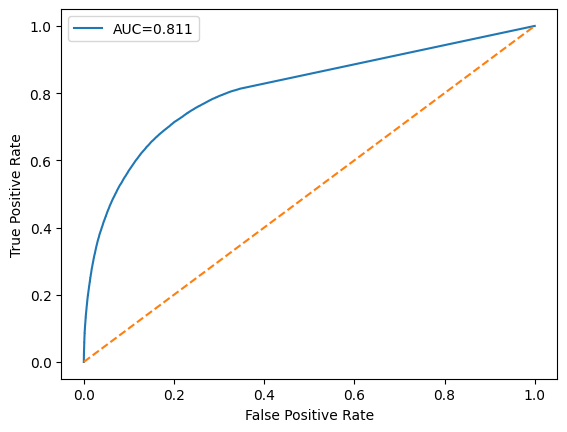

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

auc, probs, labels = evaluate_links(model, test_loader, return_scores=True)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, probs)


# Using Youden's J statistic to find the most ideal threshold for link prediction
# based on the maximal difference between true positive rate and false positive rate
j = tpr - fpr
best_idx = j.argmax()

best_threshold = thresholds[best_idx]
best_sensitivity = tpr[best_idx]
best_specificity = 1 - fpr[best_idx]

print("Best threshold:", best_threshold)
print("Sensitivity:", best_sensitivity)
print("Specificity:", best_specificity)

plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

note, we use AUC-ROC in our assessment of the sensitivity/specificity of our data since unlike F1 scores, it is not sensitive to class imbalance (differences in size between positive and negative dataset, affecting relative size of false positives and false negatives). We can also see our data without a threshold.

#final notes


* Why is the loss not increasing drastically per epoch, even if the accuracy seems to be getting better (marginally)? Is this overfitting at play?
* When the task is link prediction, the node classification does not improve, even though I would have thought they would improve together since the node classification (protein label) would likely infer information about the likelihood of interaction with another protein
* How come the F1 score for the first task (node classification) is so much worse than the F1 score for the second task, even with the class imbalance of task 2? Is there class imbalance with the first task since I'm tracking multilabel attributes? (should investigate -- because having vs not having a specific label is very likely to have a class imbalance -- may want to use roc-auc score for this as well)
* Should the actual architecture of the GCN be improved? 2 layers is likely the max number of conv layers I would want to have, but unsure about batch norm, relu (may want to switch to leaky relu), etc.  